In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):

        super(Block, self).__init__()
        # Every Resedual block will have two convolution layers with batch normalization done before applying relu
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


In [3]:

class ResNet(nn.Module):
  
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.expansion = 1 # expansion factor is 1 for resnet 18, it is 4 for resnet 50,101 and 152
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False) # Extracts the low level features from input image
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # Feature map size of 112 * 112
    self.layer1 = self.make_layer(block, layers[0], out_channels=64, stride=1) # Two convolutions with 64 outputs
    self.layer2 = self.make_layer(block, layers[1], out_channels=128, stride=2) # Two convolution with 128 outputs
    self.layer3 = self.make_layer(block, layers[2], out_channels=256, stride=2) # Two convolutions with 256 outputs
    self.layer4 = self.make_layer(block, layers[3], out_channels=512, stride=2) # Two convolution with 512 outputs
    # Feature map size of 7 * 7
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout = nn.dropout(0.2)
    self.fc = nn.Linear(512 * self.expansion, num_classes)
# Increasing the filter size will help us to create more deep model and capture complex models
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.dropout(x)
    x = self.fc(x)

    return x

  def make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None # initially identity_downsample is none
    layers = []

    if stride != 1 or self.in_channels != self.expansion * out_channels:
        identity_downsample = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion * out_channels)
        )
        # when above case occurs we create a identity_downsample with 1*1 conv layer to match number of channels

    layers.append(block(self.in_channels, out_channels, identity_downsample, stride)) # append the first residual block with matched dimensions to layers
    self.in_channels = out_channels * self.expansion # update input channels

    for i in range(num_residual_blocks - 1): # append remaining residual blocks
        layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

In [4]:
# Define transformations for data augmentation and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [5]:
pwd

'/user/ssheri'

In [6]:
data = datasets.ImageFolder('/user/ssheri/train_dataset',transform=transform)

In [7]:
data.classes

['airport_terminal',
 'amusement_park',
 'aquarium',
 'art_school',
 'auditorium',
 'bathroom',
 'beach',
 'bedroom',
 'bookstore',
 'bus_station-indoor',
 'campsite',
 'chemistry_lab',
 'clothing_store',
 'coffee_shop']

In [8]:
label_counts = torch.bincount(torch.tensor(data.targets))
for label, count in zip(data.classes, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: airport_terminal, Count: 5000
Label: amusement_park, Count: 5000
Label: aquarium, Count: 5000
Label: art_school, Count: 5000
Label: auditorium, Count: 5000
Label: bathroom, Count: 5000
Label: beach, Count: 5000
Label: bedroom, Count: 5000
Label: bookstore, Count: 5000
Label: bus_station-indoor, Count: 5000
Label: campsite, Count: 5000
Label: chemistry_lab, Count: 3447
Label: clothing_store, Count: 5000
Label: coffee_shop, Count: 3385


In [9]:
from torch.utils.data import random_split, DataLoader

In [10]:
train_size = int(0.7 * len(data))
rem = len(data) - train_size
test=int(rem/2)

train_data, test_data,val_data = random_split(data, [train_size,test,test])

In [11]:
len(train_data)

46782

In [12]:
train_loader = DataLoader(train_data, batch_size=35, shuffle=True)
test_loader = DataLoader(test_data, batch_size=35, shuffle=False)
val_loader = DataLoader(val_data,batch_size = 35, shuffle = False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
len(data.classes)

14

In [15]:


# Dropout
model = ResNet18(num_classes=len(data.classes)).to(device)
dropout = nn.Dropout(p=0.5)
model.fc = nn.Sequential(model.fc, dropout)

# Weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [16]:

num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
patience = 4
best_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    training_loss /= len(train_loader)
    train_losses.append(training_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    
    if val_loss<best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter = 1
    if counter == patience:
        print('early stopping occured')
        torch.save(model.state_dict(), 'resetearly.pth')
        break
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {training_loss:.4f},Train_accuracy : {train_accuracy:.4f}%, Val Loss: {val_loss:.4f}, Val_accuracy: {val_accuracy:.4f}%")

print('Finished Training')

Epoch [1/20] Train Loss: 2.6169,Train_accuracy : 15.4269%, Val Loss: 2.1807, Val_accuracy: 26.9726%
Epoch [2/20] Train Loss: 2.2994,Train_accuracy : 24.1867%, Val Loss: 1.9402, Val_accuracy: 39.7107%
Epoch [3/20] Train Loss: 2.1780,Train_accuracy : 28.4511%, Val Loss: 1.7244, Val_accuracy: 47.0524%
Epoch [4/20] Train Loss: 2.0738,Train_accuracy : 31.5741%, Val Loss: 1.6333, Val_accuracy: 52.2294%
Epoch [5/20] Train Loss: 1.9929,Train_accuracy : 33.7053%, Val Loss: 1.4611, Val_accuracy: 58.0349%
Epoch [6/20] Train Loss: 1.9297,Train_accuracy : 35.5457%, Val Loss: 1.4642, Val_accuracy: 56.6484%
Epoch [7/20] Train Loss: 1.8676,Train_accuracy : 37.2836%, Val Loss: 1.4324, Val_accuracy: 56.4090%
Epoch [8/20] Train Loss: 1.8215,Train_accuracy : 38.5063%, Val Loss: 1.2643, Val_accuracy: 62.0948%
Epoch [9/20] Train Loss: 1.7998,Train_accuracy : 39.0599%, Val Loss: 1.5521, Val_accuracy: 51.9401%
Epoch [10/20] Train Loss: 1.7680,Train_accuracy : 39.7482%, Val Loss: 1.2113, Val_accuracy: 64.9975%

In [17]:
# 6. Save the best model
torch.save(model.state_dict(), 'resnet_new.pth')

In [18]:
correct = 0
total = 0
y_true = []
y_pred = []
test_losses = []
test_accuracies = []
test_loss = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs= inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
test_loss /= len(val_loader)
test_accuracy = 100 * correct / total
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print('Accuracy of the network on the test images: %d %%' % (test_accuracy))
print('Test loss is ',(test_loss))

Accuracy of the network on the test images: 71 %
Test loss is  0.9818776769089782


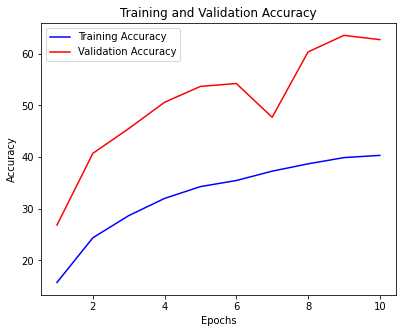

In [21]:

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


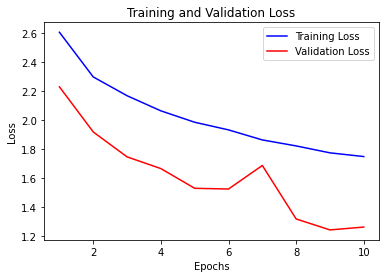

In [22]:
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
from sklearn.metrics import confusion_matrix

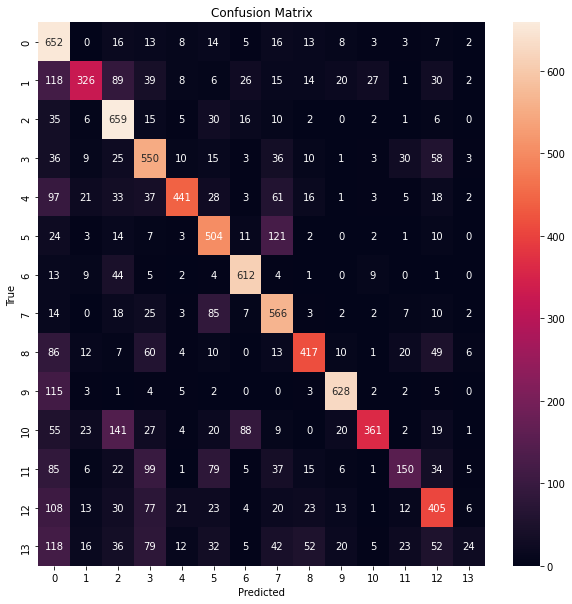

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()